In [1]:
from collections import OrderedDict
import timm, torch, argparse, yaml, pickle
from softdataset import TripletImageDataset
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader
from collections import OrderedDict as OD
import numpy as np
from tqdm import tqdm
from torchvision import transforms
import torchvision.transforms.functional as FF
from torch.nn import functional as F
import AutoAugment
from torch.nn import *
from torch import nn
from PIL import Image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from collections import namedtuple as NT

/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Test Set

In [13]:
class ContrastiveLoss(nn.Module):

        """

        Contrastive loss

        Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise

        """

        def __init__(self, margin):
            super(ContrastiveLoss, self).__init__()
            self.margin = margin
            self.eps = 1e-9

        def forward(self, output1, output2, target, size_average=True):
            distances = (output2 - output1).pow(2).sum(1)  # squared distances
            losses = 0.5 * (target * distances + (1 + -1 * target) * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
            return losses.mean() if size_average else losses.sum()
    

def get_dl(ims_path, test_path, bs):        

    ''' 

    Get the path to the pickle file with test images and 
    returns the dataset with a dataloader.
    Arguments:

    ims_path - path to the dir with the images of the whole dataset (to get the number of classes);
    test_path - path to the dir with test images saved as a pickle file
    bs - batch_size;
    
    '''
    
    dataset = TripletImageDataset(data_dir=ims_path)
    num_classes = dataset.get_prod_length()
    print(f"The dataset has {num_classes} classes")
    
    with open(path, 'rb') as handle:
        dataset_pickle = pickle.load(handle)  
    print(f"Number of test samples: {len(dataset_pickle)}")
    
    test_dl = DataLoader(dataset_pickle, batch_size=bs, shuffle=True, drop_last=True, num_workers=8)

    return num_classes, dataset_pickle, test_dl


def load_checkpoint(checkpoint_path, model_name, pretrained=False, num_classes=None, from_pytorch_lightning=True, init_conv=False):

        ''' 
        
        Loads checkpoint_path from the given path to the directory with the trained model.
        Arguments:
        
        checkpoint_path - path to the dir with the trained model;
        model_name - name of the trained model (name is the same as in the timm library);
        pretrained - creates a model with pretrained weights on ImageNet;
        init_conv - initial convolution layer, default is True;
        from_pytorch_lightning - used to load the trained model from pytorch_lightning.
        If True the model is trained using pytorch_lightning, else with a regular torch library;
        Default is False
        
        '''        
        assert num_classes is not None, "Please set the number of classes in the dataset!"
        
        if from_pytorch_lightning: # for a pytorch_lightning model
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            # print(checkpoint['state_dict'].keys())
            if init_conv:                
                base_model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
                conv_layer = torch.nn.Sequential(torch.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1),padding=(1,1), bias=False), 
                 # nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2),padding=(1,1), bias=False), 
                 # nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1)),
                 torch.nn.SiLU(inplace=True))
                model = torch.nn.Sequential(conv_layer, base_model) 
                print("Model with init_conv True")
            else:
                model = timm.create_model(model_name, num_classes=num_classes)
                print("Model with init_conv False")

            # create new OrderedDict that does not contain `model.` (for the checkpoint from the pytorch_lightning)
            new_state_dict = OrderedDict()
            for k, v in checkpoint['state_dict'].items():
                name = k.replace("model.", "") # remove `model.`
                new_state_dict[name] = v
            # load params
            model.load_state_dict(new_state_dict, strict=True)
            print(f"Model {model_name} trained using pytorch lightning checkpoint is successfully loaded!")

        else: # for a regular torch model  
            if pretrained:
                model = timm.create_model(model_name, num_classes=num_classes)
                print(f"Model {model_name} with pretrained weights is successfully loaded!")
            else:
                model = timm.create_model("rexnet_150")
                state_dict = torch.load(checkpoint_path)
                model.load_state_dict(state_dict['state_dict'])
                num_features = model.head.fc.in_features
                model.classifier = Linear(num_features, num_classes) if num_classes > 0 else Identity() 
                print(f"Model {model_name} with the best weights is successfully loaded!")            

        return model
    
def inference(model, dataloader, device):

        ''' 
        
        Loads checkpoint from the given path to the directory with the trained model.
        Arguments:
        
        checkpoint - path to the dir with the trained model;
        model_name - name of the trained model (name is the same as in the timm library);
        from_pytorch_lightning - used to load the trained model from pytorch_lightning.
        If True the model is trained using pytorch_lightning, else with a regular torch library;
        Default is False
        
        '''   
        
        loss_module = torch.nn.CosineEmbeddingLoss(margin=0.5).to('cuda')
        pool = nn.AvgPool2d((7,7))
        # loss_module = nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y))
        ims, poss, scores, fms_ims_all, fms_poss_all, fms_negs_all, losses, classes_all = [], [], [], [], [], [], [], []
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        model.to(device)
        model.eval()
        
        def forward(inp):
            def dict_to_namedtuple(dic):
                return NT('GenericDict', dic.keys())(**dic)

            dic = {}                        
            fm = model.forward_features(inp)
            pool = nn.AvgPool2d((7,7))
            lbl = model.forward_head(fm)
            dic["feature_map"] = torch.reshape(pool(fm), (-1, fm.shape[1]))
            dic["class_pred"] = lbl
            out = dict_to_namedtuple(dic)
            return out
        
        model.forward = forward
        print("Obtaining embeddings...")
        
        for i, batch_all in tqdm(enumerate(dataloader)):
            ims_all, poss_all, negs_all, clss_all, regs_all = batch_all['qry'], batch_all['pos'][0], batch_all['neg'][0], batch_all['cat_idx'], batch_all['prod_idx']
            ims.extend(ims_all)
            poss.extend(poss_all)
            classes_all.extend(regs_all) 
            
            with torch.no_grad():
                # with torch.cuda.amp.autocast():
                out_ims_all = model(ims_all.to(device))            
                # print(out_ims_all1.shape)
                fm_ims_all, lbl_ims_all = out_ims_all[0], out_ims_all[1] # get feature maps [0] and predicted labels [1]
                # print(fm_ims_all.shape)
                # print(lbl_ims_all.shape)
                out_poss_all = model(poss_all.to(device))
                fm_poss_all, lbl_poss_all = out_poss_all[0], out_poss_all[1] # get feature maps [0] and predicted labels [1]
                # print(fm_poss_all.shape)
                out_negs_all = model(negs_all.to(device))
                fm_negs_all, lbl_negs_all = out_negs_all[0], out_negs_all[1] # get feature maps [0] and predicted labels [1]
                fms_ims_all.extend(fm_ims_all)
                fms_poss_all.extend(fm_poss_all)
                fms_negs_all.extend(fm_negs_all)
        print("Embeddings are obtained!")        
        print("Calculating metrics...")
        top1 = 0 
        top3 = 0
        fms_ims_all = torch.stack(fms_ims_all)
        fms_poss_all = torch.stack(fms_poss_all)
        fms_negs_all = torch.stack(fms_negs_all)        
        ims = torch.stack(ims)
        poss = torch.stack(poss)        
        
        for idx, fm in enumerate(fms_ims_all):
            score = cos(fm.unsqueeze(0), fms_poss_all[idx].unsqueeze(0)) #(1, fm)                                
            print(score)
            scores.append((score).item())
            vals, inds = torch.topk(cos(fm, fms_poss_all), k=3)
            # vals, inds = torch.topk(torch.cdist(fm.unsqueeze(0), fms_poss_all), k=3)
            # vals, inds = torch.topk(pdist(fm.unsqueeze(0), fms_poss_all), k=3)
            # print(f"Poss top3 sim scores: {vals}")
            vals1, inds1 = torch.topk(cos(fm, fms_negs_all), k=3)
            # vals1, inds1 = torch.topk(torch.cdist(fm.unsqueeze(0), fms_negs_all), k=3)
            # vals1, inds1 = torch.topk(pdist(fm.unsqueeze(0), fms_negs_all), k=3)
            # print(f"Negs top3 sim scores: {vals1}\n")
            top3 += len(inds[idx == inds])
            top1 += len(inds[idx == inds[0]])
            
        return OD([('loss', np.mean(losses)), ('top1', top1/len(fms_ims_all)), ('top3', top3/len(fms_ims_all)), 
                   ('scores', torch.mean(torch.FloatTensor(scores))), ('fms_ims_all', fms_ims_all), ('s', scores), 
                   ('fms_poss_all', fms_poss_all), ('ims', ims), ('poss', poss), ('fms_negs_all', fms_negs_all)])

In [17]:
test_path = "/home/ubuntu/workspace/bekhzod/pytorch_lightning/data/20221121-175851-test_ds.pickle"
ims_path = "/mnt/test_dataset_svg/test_dataset_svg_1118_2"
bs=16
checkpoint_path = "/home/ubuntu/workspace/bekhzod/pytorch_lightning/epoch=34-val_loss=0.76-cos_sims=0.27-val_top3=30.83.ckpt" #change checkpoint
num_classes, test_ds, test_dl = get_dl(ims_path=ims_path, test_path=test_path, bs=bs)
device = 'cuda:1'
m = load_checkpoint(checkpoint_path, num_classes=num_classes, model_name='rexnet_150')
results = inference(m, test_dl, device)
results['top3'], results['top1'], results['scores']

The dataset has 112 classes
Number of test samples: 373
Model with init_conv False
Model rexnet_150 trained using pytorch lightning checkpoint is successfully loaded!
Obtaining embeddings...


23it [00:04,  5.11it/s]


Embeddings are obtained!
Calculating metrics...
tensor([0.8009], device='cuda:1')
tensor([0.7844], device='cuda:1')
tensor([0.5712], device='cuda:1')
tensor([0.6891], device='cuda:1')
tensor([0.7474], device='cuda:1')
tensor([0.5921], device='cuda:1')
tensor([0.3880], device='cuda:1')
tensor([0.6065], device='cuda:1')
tensor([0.5556], device='cuda:1')
tensor([0.8158], device='cuda:1')
tensor([0.7442], device='cuda:1')
tensor([0.4923], device='cuda:1')
tensor([0.6467], device='cuda:1')
tensor([0.9160], device='cuda:1')
tensor([0.4900], device='cuda:1')
tensor([0.6373], device='cuda:1')
tensor([0.8060], device='cuda:1')
tensor([0.7000], device='cuda:1')
tensor([0.7000], device='cuda:1')
tensor([0.7211], device='cuda:1')
tensor([0.6748], device='cuda:1')
tensor([0.6383], device='cuda:1')
tensor([0.6244], device='cuda:1')
tensor([0.7289], device='cuda:1')
tensor([0.6780], device='cuda:1')
tensor([0.5684], device='cuda:1')
tensor([0.6025], device='cuda:1')
tensor([0.5430], device='cuda:1')


/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.4483695652173913, 0.1956521739130435, tensor(0.6465))

In [ ]:
# checkpoint_path = "/home/ubuntu/workspace/bekhzod/pytorch_lightning/epoch=34-val_loss=0.76-cos_sims=0.27-val_top3=30.83.ckpt" #change checkpoint
# test_ds, test_dl = get_dl(data_name='test', cache = cache)
# device = 'cuda:1'
# m = load_checkpoint(checkpoint_path, model_name='rexnet_150')
# loss_module = torch.nn.CosineEmbeddingLoss(margin=0.5).to('cuda')
# pool = nn.AvgPool2d((7,7))
# cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
# m.to(device)
# m.eval()
# def forward(inp):
#     def dict_to_namedtuple(dic):
#         return NT('GenericDict', dic.keys())(**dic)
#     dic = {}                        
#     fm = m.forward_features(inp)
#     pool = nn.AvgPool2d((7,7))
#     lbl = m.forward_head(fm)
#     dic["feature_map"] = torch.reshape(pool(fm), (-1, fm.shape[1]))
#     dic["class_pred"] = lbl
#     out = dict_to_namedtuple(dic)
#     return out
# m.forward = forward
# a = torch.rand(1,3,224,224)
# m(a.to(device))[0].shape, m(a.to(device))[1].shape

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
ff = []
aa = []
b= []
for idx, item in enumerate(results['fms_ims_all']):
    adf = cos(item, results['fms_poss_all'][idx].unsqueeze(0))
    ccc = cos(item, results['fms_poss_all'])[idx]
    nnn = cos(item, results['fms_negs_all'])[idx]
    ff.append(adf.item())
    aa.append(ccc.item())
    b.append(nnn.item())
    # fms_poss_all
np.mean(ff), np.mean(aa), np.mean(b)


Input Image


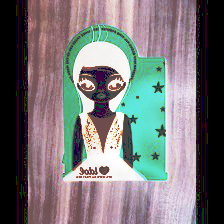


Positive Image



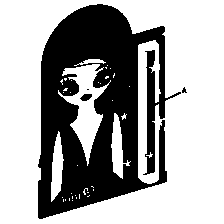


Predicted Images



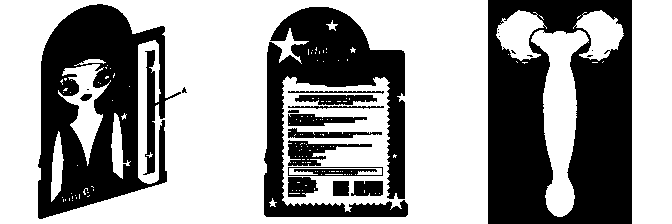

1 1 0.8009331226348877 0.8009331226348877

Input Image


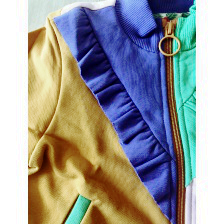


Positive Image



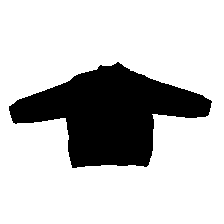


Predicted Images



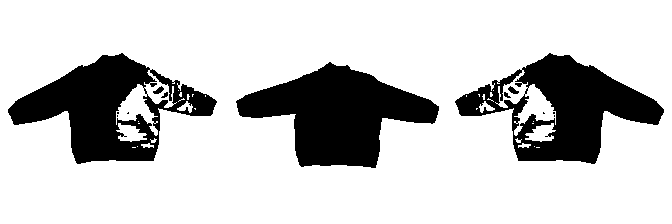

0 0 0.7843506336212158 0.8047762513160706

Input Image


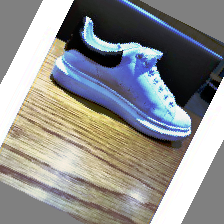


Positive Image



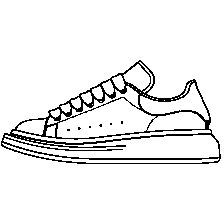


Predicted Images



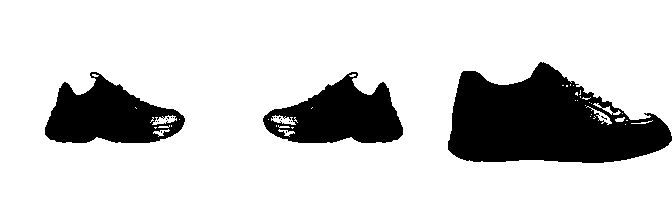

0 0 0.571199893951416 0.6583478450775146

Input Image


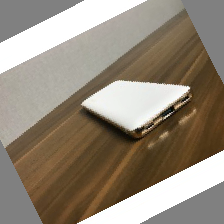


Positive Image



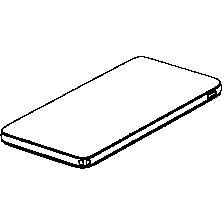


Predicted Images



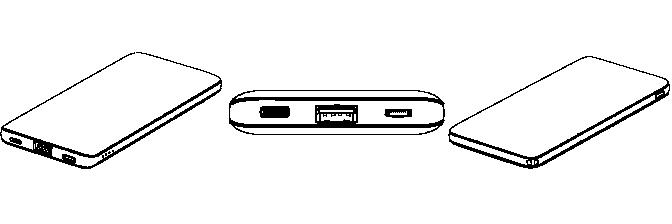

1 0 0.6891106367111206 0.7027353048324585

Input Image


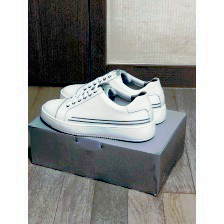


Positive Image



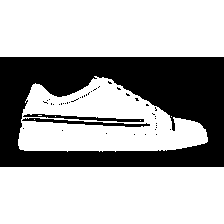


Predicted Images



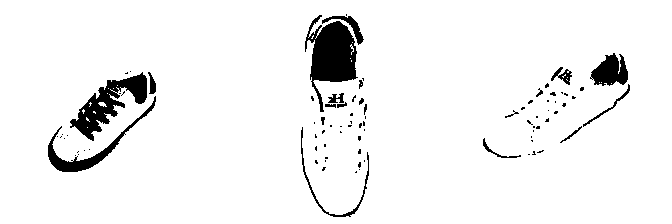

0 0 0.7473779916763306 0.7857623100280762

Input Image


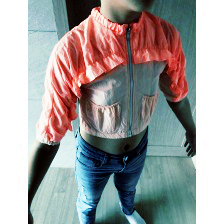


Positive Image



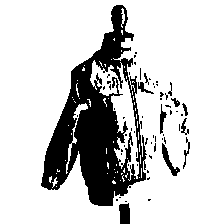


Predicted Images



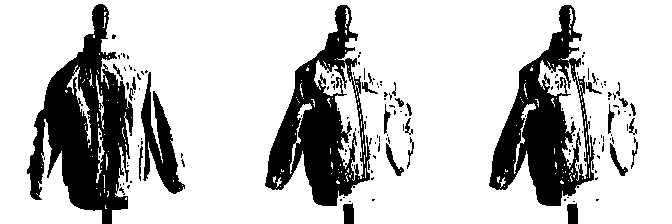

1 0 0.5920631289482117 0.6028328537940979

Input Image


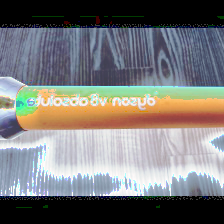


Positive Image



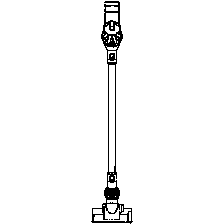


Predicted Images



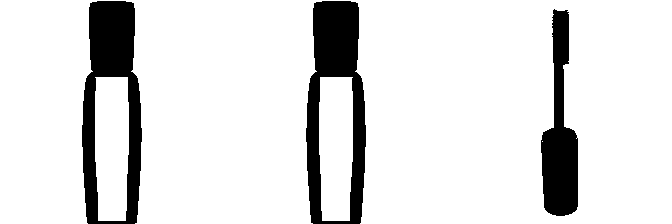

0 0 0.38796889781951904 0.7149304151535034

Input Image


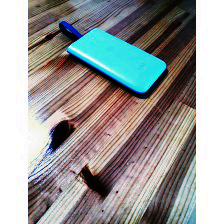


Positive Image



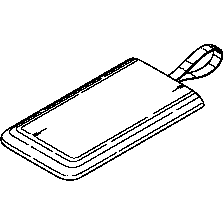


Predicted Images



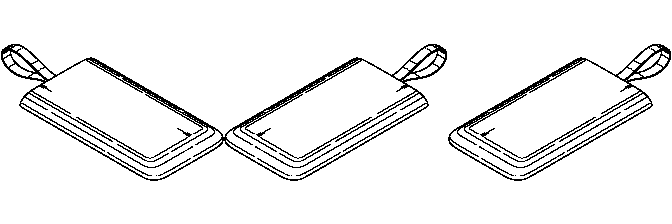

1 0 0.606523871421814 0.6472723484039307

Input Image


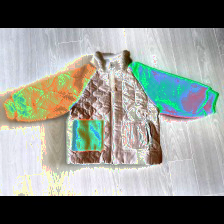


Positive Image



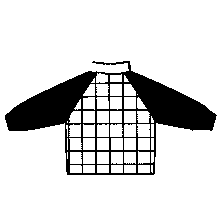


Predicted Images



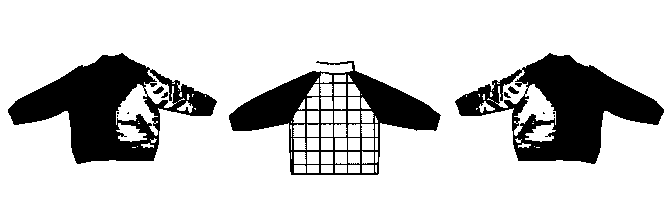

1 0 0.5556493997573853 0.572564959526062

Input Image


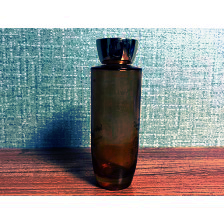


Positive Image



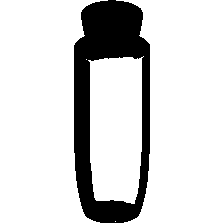


Predicted Images



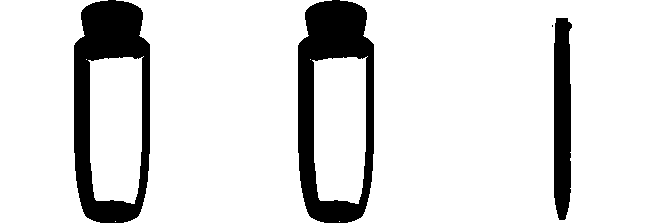

1 0 0.8158481121063232 0.8158481121063232


In [18]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                 std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                 std = [ 1., 1., 1. ]),
                           ])
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
scores = results['s']
fms_ims_all = results['fms_ims_all']
fms_poss_all = results['fms_poss_all']
fms_negs_all = results['fms_negs_all']
ims = results['ims']
poss = results['poss']
# negs = results['negs']

top3, top1, cnt = 0, 0, 0
    
for i, im in enumerate(ims):
    if i == 10:
        break
    print('\nInput Image')
    display(Image.fromarray((invTrans(ims[i])*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)))
    print('\nPositive Image\n')
    display(Image.fromarray((invTrans(poss[i])*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)))
    cnt += 1
    values, indices = torch.topk(cos(fms_ims_all[i], fms_poss_all), k=3)
    top3 = len(indices[i == indices])
    top1 = len(indices[i == indices[0]])

    img_list = []
    img_list_gt = []
    for j in indices:
        img = (invTrans(poss[j])*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)
        img_gt = (invTrans(poss[i])*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)
        img_list.append(img)
        img_list_gt.append(img_gt)
    print('\nPredicted Images\n')
    display(Image.fromarray(np.concatenate(img_list, axis=1)))
    # print('\nGT sketch \n')
    # display(Image.fromarray(np.concatenate(img_list_gt, axis=1)))

    print(top3, top1, scores[i], values[0].item())